In [177]:
import numpy as np
import pandas as pd
from sklearn . model_selection import train_test_split
from sklearn . metrics import confusion_matrix , classification_report
import matplotlib . pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Fonctions d’activation
def relu (x ):
    """
    ReLU activation : max (0 , x)
    """
    assert isinstance (x , np . ndarray ) , " Input to ReLU must be a numpy array "
    result = np . maximum (0 , x)
    assert np . all ( result >= 0) , " ReLU output must be non - negative "
    return result
def relu_derivative ( x) :
    """
    Derivative of ReLU : 1 if x > 0 , else 0
    """
    assert isinstance (x , np . ndarray ) , " Input to ReLU derivative must be a numpy array "
    result = np . where ( x > 0 , 1 , 0)
    assert np . all (( result == 0) | ( result == 1) ) , " ReLU derivative must be 0 or 1"
    return result

def sigmoid ( x):
    """
    Sigmoid activation : 1 / (1 + exp ( -x))
    """
    assert isinstance (x , np . ndarray ) , " Input to sigmoid must be a numpy array "
    result = 1 / (1 + np . exp ( -x))
    assert np . all (( result >= 0) & ( result <= 1) ) , " Sigmoid output must be in [0 , 1]"

    return result

def sigmoid_derivative (x) :
    """
    Derivative of sigmoid : sigmoid (x) * (1 - sigmoid (x))
    """
    assert isinstance (x , np . ndarray ) , " Input to sigmoid derivative must be a numpy array "
    result = sigmoid (x) * (1 - sigmoid (x))
    assert np . all (( result >= 0) & ( result <= 0.25) ) , " Sigmoid derivative must be in [0 , 0.25] "

    return result

In [181]:
# Classe NeuralNetwork
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01,lamda = 0.1, optimiseur = 'SGD'):
        """
        Initialize the neural network with given layer sizes and learning rate.

        layer_sizes : List of integers [input_size, hidden1_size, ..., output_size]

        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"

        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"

        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"


        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.lamda = lamda
        self.optimiseur = optimiseur
        self.optimizer_instance = None

        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            b = np.zeros((1, layer_sizes[i + 1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i + 1]), f"Weight matrix {i + 1} has incorrect shape"

            assert b.shape == (1, layer_sizes[i + 1]), f"Bias vector {i + 1} has incorrect shape"

            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]}W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})

        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"

        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i + 1]), f"Z^{[i + 1]} has incorrect shape"
            self.z_values.append(z)
            a = relu(z)
            assert a.shape == (X.shape[0], self.layer_sizes[i + 1]), f"A^{[i + 1]} has incorrect shape"
            self.activations.append(a)

        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"

        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy: J = -1/m * sum(y * log(y_pred) + (1 - y) * log(1 - y_pred))
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"

        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np . all (( y_true == 0) | ( y_true == 1) ) , " y_true must contain only 0s and 1s"

        m = y_true.shape[0]
        loss = -1 / m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss


    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"

        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        # y_true is assumed to be binary (0 or 1)

        # Ensure y_pred is converted to binary predictions (0 or 1) for accuracy calculation
        # Assuming the output layer uses sigmoid, a threshold of 0.5 is typical.
        y_pred_binary = (y_pred > 0.5).astype(int)


        correct_predictions = np.sum(y_true == y_pred_binary)
        accuracy = correct_predictions / y_true.shape[0]

        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"

        return accuracy


    def backward(self, X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"

        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        assert y.shape == outputs.shape, "y and outputs must have the same shape"


        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        # Calculate dZ for the output layer
        # For binary cross-entropy with sigmoid, dZ = A_out - Y
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"

        # Calculate gradients for the output layer
        # dW = 1/m * A_prev.T @ dZ
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        # db = 1/m * sum(dZ, axis=0)
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Propagate gradients backward through hidden layers
        # Loop from the second to last layer back to the first layer
        for i in range(len(self.weights) - 2, -1, -1):
            # Propagate dA from the layer above: dA = dZ_next @ W_next.T
            dA = dZ @ self.weights[i + 1].T
            # Calculate dZ for the current layer: dZ = dA * g'(Z)
            dZ = dA * relu_derivative(self.z_values[i])
            assert dZ.shape == self.z_values[i].shape, f"dZ for layer {i + 1} has incorrect shape"
            # Compute gradients for current layer weights and biases
            # Use the activation of the current layer (self.activations[i]) as A_prev
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # Add L2 regularization to weight gradients
        for i in range(len(self.weights)):
            # dW_reg = lambda/m * W
            self.d_weights[i] += self.lamda * self.weights[i] / m

        # The actual weight and bias updates will happen in the train method based on the optimizer

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD, with validation

        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"

        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"



        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"

        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"


        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Initialize optimizer before training
        if self.optimiseur == 'Adam':
              self.optimizer_instance = AdamOptimizer(learning_rate=self.learning_rate)
              self.optimizer_instance.initialize(self.weights, self.biases)
        elif self.optimiseur != 'SGD':
             raise ValueError(f"Optimizer '{self.optimiseur}' not supported. Choose 'SGD' or 'Adam'.")


        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            # Check if batch_size is larger than the number of samples
            if batch_size > X_shuffled.shape[0]:
                 print(f"Warning: Batch size ({batch_size}) is larger than the number of training samples ({X_shuffled.shape[0]}). Using full dataset as a single batch.")
                 batch_size = X_shuffled.shape[0]


            num_batches = max(1, X_shuffled.shape[0] // batch_size) # Ensure at least one batch

            for i in range(0, X_shuffled.shape[0], batch_size):
                X_batch = X_shuffled[i : i + batch_size]
                y_batch = y_shuffled[i : i + batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs) # Compute gradients

                # Update weights and biases using the chosen optimizer
                if self.optimiseur == 'SGD':
                    for j in range(len(self.weights)):
                        self.weights[j] -= self.learning_rate * self.d_weights[j]
                        self.biases[j] -= self.learning_rate * self.d_biases[j]
                elif self.optimiseur == 'Adam':
                     self.weights, self.biases = self.optimizer_instance.update(self.weights, self.biases, self.d_weights, self.d_biases)


            # Calculer les pertes et accuracies pour l’e n t r a n e m e n t et la validation
            train_loss = epoch_loss / num_batches
            # Recalculate outputs for the full shuffled dataset for train accuracy
            train_outputs_full = self.forward(X_shuffled)
            train_accuracy = self.compute_accuracy(y_shuffled, train_outputs_full)


            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            val_accuracy = self.compute_accuracy(y_val, val_outputs)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


        return train_losses, val_losses, train_accuracies, val_accuracies


    def predict(self, X):
        """
        Predict class labels (0 or 1)
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"

        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        predictions = self.forward(X)
        # Convert probabilities to class labels (0 or 1)
        predictions = (predictions > 0.5).astype(int)

        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"

        return predictions

Epoch 0, Train Loss: 0.6321, Val Loss: 0.5704, Train Acc: 0.7413, Val Acc: 0.7185
Epoch 10, Train Loss: 0.4785, Val Loss: 0.5282, Train Acc: 0.7960, Val Acc: 0.7852
Epoch 20, Train Loss: 0.4667, Val Loss: 0.5062, Train Acc: 0.8134, Val Acc: 0.7556
Epoch 30, Train Loss: 0.4690, Val Loss: 0.5204, Train Acc: 0.7935, Val Acc: 0.7630
Epoch 40, Train Loss: 0.4406, Val Loss: 0.5828, Train Acc: 0.8134, Val Acc: 0.7852
Epoch 50, Train Loss: 0.4640, Val Loss: 0.5053, Train Acc: 0.8060, Val Acc: 0.7778
Epoch 60, Train Loss: 0.4843, Val Loss: 0.5488, Train Acc: 0.7861, Val Acc: 0.7259
Epoch 70, Train Loss: 0.4774, Val Loss: 0.5562, Train Acc: 0.7786, Val Acc: 0.7333
Epoch 80, Train Loss: 0.4675, Val Loss: 0.5471, Train Acc: 0.7861, Val Acc: 0.7704
Epoch 90, Train Loss: 0.4824, Val Loss: 0.5704, Train Acc: 0.7960, Val Acc: 0.7185
Epoch 0, Train Loss: 0.8389, Val Loss: 0.5223, Train Acc: 0.7944, Val Acc: 0.7284
Epoch 10, Train Loss: 0.5469, Val Loss: 0.5289, Train Acc: 0.7601, Val Acc: 0.6914
Epoch 

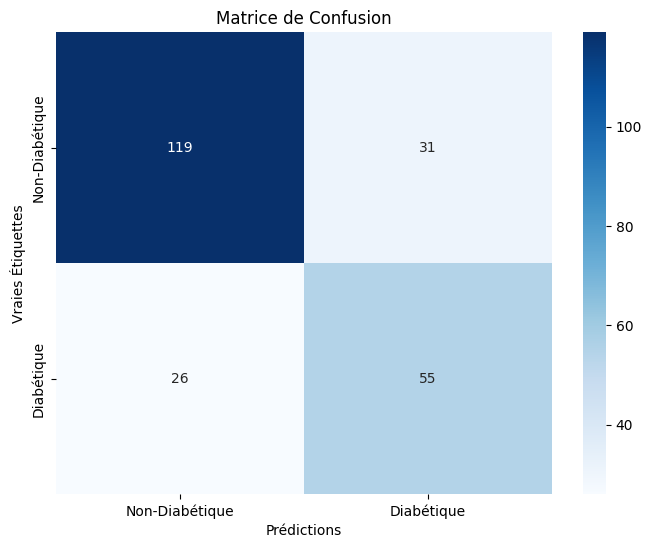

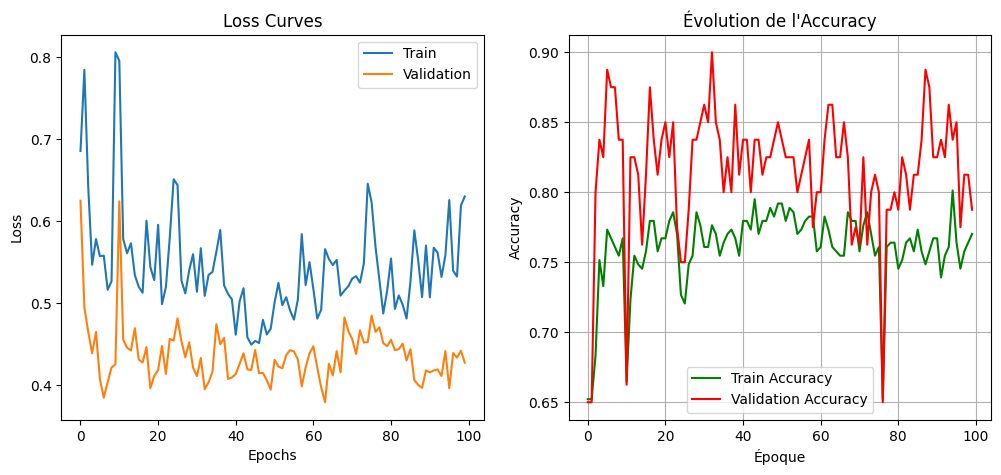

les resultas sans CV
\ nRapport de classification ( Test set ) :
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       150
           1       0.63      0.81      0.71        81

    accuracy                           0.77       231
   macro avg       0.76      0.78      0.76       231
weighted avg       0.80      0.77      0.78       231



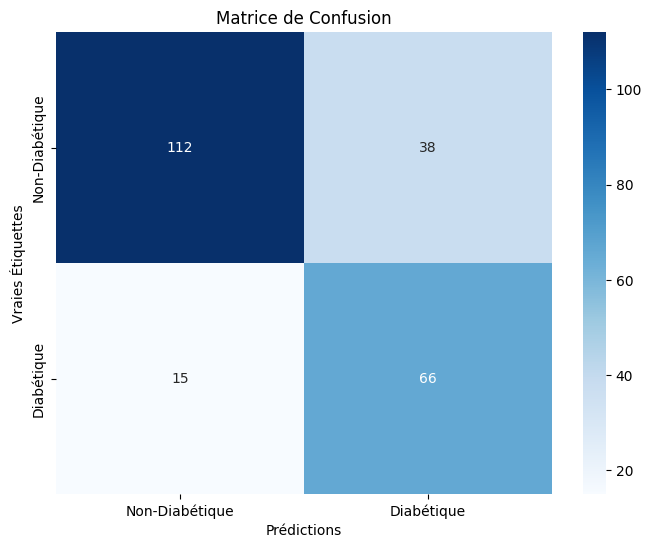

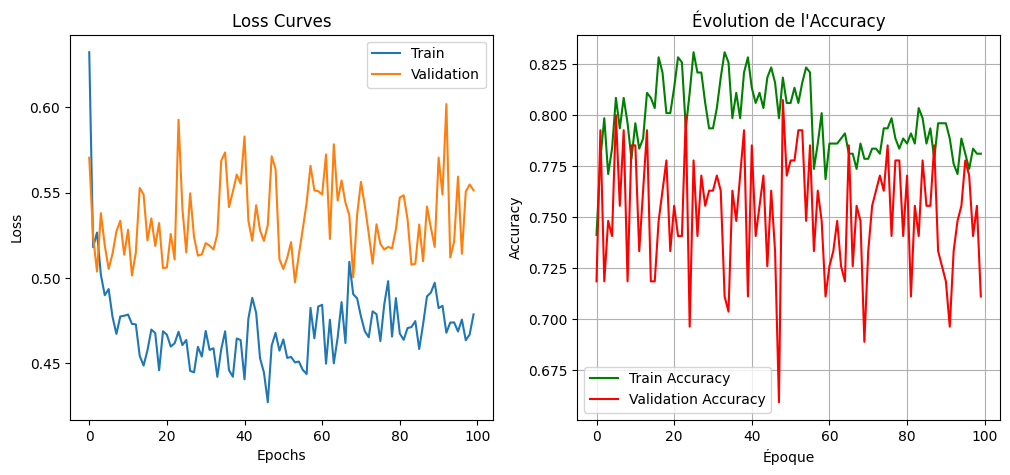

In [180]:
from sklearn.impute import SimpleImputer
# Charger et p r p a r e r les d o n n e s
data = pd.read_csv ('diabetes.csv')
colonnes = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Remplacer 0 par np.nan
data[colonnes] = data[colonnes].replace(0, np.nan)
data[colonnes] = data[colonnes].astype(float)
imputer = SimpleImputer(strategy='median')
data[colonnes] = imputer.fit_transform(data[colonnes])
X = data . drop ('Outcome' , axis =1 ). values
y = data ['Outcome'].values
y = y.reshape(-1,1)
# TODO
assert X. shape [0] == y. shape [0] , " Number of samples in X and y must match "
assert X. shape [1] == 8, " Expected 8 features in input data "

# Standardisation : X = (X - mu) / sigma
mu = np . mean (X , axis =0 )
sigma = np . std (X , axis =0 )
X = (X - mu) / sigma
# TODO

# Diviser les d o n n e s en e n t r a n e m e n t , validation et test
X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size=0.3 , stratify =y , random_state =42)
X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp ,test_size =0.25 , stratify = y_temp , random_state =42)
assert X_train . shape [0] + X_val . shape [0] + X_test . shape [0] == X.shape [0] , "Train -val - test split sizes must sum to total samples"



# C r e r et e n t r a n e r le m o d l e
layer_sizes = [ X_train . shape [1] , 16 , 8, 1]
nn = NeuralNetwork ( layer_sizes , learning_rate =0.1,lamda = 0.1, optimiseur = 'Adam')
train_losses , val_losses , train_accuracies , val_accuracies = nn .train ( X_train , y_train , X_val , y_val , epochs =100 , batch_size=32)

# TODO : Ajouter une validation c r o i s e pour valuer la robustesse du m o d l e
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in cv.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    nn_cv = NeuralNetwork ( layer_sizes , learning_rate =0.1,lamda = 0.1, optimiseur = 'Adam')
    train_losses_cv, val_losses_cv, train_accuracies_cv, val_accuracies_cv  = nn_cv.train(X_train_cv, y_train_cv, X_val_cv, y_val_cv, epochs=100, batch_size=32)




# P r d i c t i o n s et valuation
y_pred = nn_cv.predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))
print('==========================================================')
print('les resultas de CV')
print('==========================================================')
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabétique', 'Diabétique'], yticklabels=['Non-Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraies Étiquettes')
plt.xlabel('Prédictions')
# TODO
plt . show ()
# Courbes de perte et d’accuracy
fig , ( ax1 , ax2 ) = plt . subplots (1 , 2, figsize =(12 , 5) )
# Courbe de perte
ax1 . plot ( train_losses_cv , label ='Train')
ax1 . plot ( val_losses_cv , label ='Validation')
ax1 . set_xlabel ('Epochs')
ax1 . set_ylabel ('Loss')
ax1 . set_title ('Loss Curves')
ax1 . legend ()
# courbe d'accuracy
ax2.plot(train_accuracies_cv, label='Train Accuracy', color='green')
ax2.plot(val_accuracies_cv, label='Validation Accuracy', color='red')
ax2.set_title('Évolution de l\'Accuracy')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
# TO DO
plt . show ()

# TODO : I m p l m e n t e r l’optimiseur Adam pour une meilleure convergence

# Optimiseur Adam (classe simple)
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_weights = []
        self.v_weights = []
        self.m_biases = []
        self.v_biases = []
        self.t = 0  # time step

    def initialize(self, weights, biases):
        self.m_weights = [np.zeros_like(w) for w in weights]
        self.v_weights = [np.zeros_like(w) for w in weights]
        self.m_biases = [np.zeros_like(b) for b in biases]
        self.v_biases = [np.zeros_like(b) for b in biases]

    def update(self, weights, biases, d_weights, d_biases):
        self.t += 1
        for i in range(len(weights)):
            # Update moments for weights
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * d_weights[i]
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (d_weights[i] ** 2)

            # Bias correction
            m_hat_w = self.m_weights[i] / (1 - self.beta1 ** self.t)
            v_hat_w = self.v_weights[i] / (1 - self.beta2 ** self.t)

            # Update weights
            weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)

            # Update moments for biases
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * d_biases[i]
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (d_biases[i] ** 2)

            # Bias correction
            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** self.t)

            # Update biases
            biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)
        return weights, biases
print('==========================================================')
print('les resultas sans CV')
print('==========================================================')
# P r d i c t i o n s et valuation
y_pred = nn . predict ( X_test )
print ("\ nRapport de classification ( Test set ) :")
print ( classification_report ( y_test , y_pred ))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabétique', 'Diabétique'], yticklabels=['Non-Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraies Étiquettes')
plt.xlabel('Prédictions')
# TODO
plt . show ()

# Courbes de perte et d’accuracy
fig , ( ax1 , ax2 ) = plt . subplots (1 , 2, figsize =(12 , 5) )
# Courbe de perte
ax1 . plot ( train_losses , label ='Train')
ax1 . plot ( val_losses , label ='Validation')
ax1 . set_xlabel ('Epochs')
ax1 . set_ylabel ('Loss')
ax1 . set_title ('Loss Curves')
ax1 . legend ()
# courbe d'accuracy
ax2.plot(train_accuracies, label='Train Accuracy', color='green')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Évolution de l\'Accuracy')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
# TO DO
plt . show ()